# Récupération des info de geo-localisation des villes

## Imports python

In [1]:
import pandas as pd
import requests
import time
import plotly.express as px

from config import (
    CITIES_GEO_LOCATION_CSV_PATH
)

import plotly.io as pio

# Allow to view a preview image within Github
pio.renderers.default = "jupyterlab+png"

Data folder: /workspaces/jedha-cdsd-cert-projects/bloc-1/kayak/data


## Liste prédéfinie des villes à proposer à la visite

In [2]:
# top 35 des villes à visiter en France (périmètre du projet)

TOP_35_CITIES_FR = ["Mont Saint Michel",
"St Malo",
"Bayeux",
"Le Havre",
"Rouen",
"Paris",
"Amiens",
"Lille",
"Strasbourg",
"Chateau du Haut Koenigsbourg",
"Colmar",
"Eguisheim",
"Besancon",
"Dijon",
"Annecy",
"Grenoble",
"Lyon",
"Gorges du Verdon",
"Bormes les Mimosas",
"Cassis",
"Marseille",
"Aix en Provence",
"Avignon",
"Uzes",
"Nimes",
"Aigues Mortes",
"Saintes Maries de la mer",
"Collioure",
"Carcassonne",
"Ariege",
"Toulouse",
"Montauban",
"Biarritz",
"Bayonne",
"La Rochelle"]


## Fonction d'interrogation de l'API de géo-locatisation (Nominatim web service)

Endpoint utilisé: https://nominatim.org/release-docs/develop/api/Search/

In [7]:
# Common nominatim API settings (https://nominatim.org/release-docs/develop/api/Search/)
NOMINATIM_SEARCH_API_URL = 'https://nominatim.openstreetmap.org/search'

NOMINATIM_SEARCH_HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/135.0.0.0 Safari/537.36 Edg/135.0.0.0',
    'Accept': 'application/json',
}

# Batch search function
def get_cities_geo_locations(cities: list[str], country = "France") -> pd.DataFrame:
    # a list to collect all destinations with their locations
    locations = []

    for city in cities:
        print(f"locating city: {city}...")

        search_query = f"{city},{country}"
        params = {'q': search_query, 'format': 'json'}

        try:
            response = requests.get(NOMINATIM_SEARCH_API_URL, headers=NOMINATIM_SEARCH_HEADERS, params=params)
            response.raise_for_status()
            
            # No heavy uses (an absolute maximum of 1 request per second is allowed by Nominatim service).
            time.sleep(1)
        except requests.exceptions.RequestException as e:
            print(f"Error while querying location for {city}:", e)
        else:
            city_search_results = response.json()
            if city_search_results and len(city_search_results) > 0:
                latitude = city_search_results[0]['lat']
                longitude = city_search_results[0]['lon']
                
                location = {'name': city, 'latitude': latitude, 'longitude': longitude}
                locations.append(location)

                print(f"New location: {location}")
            else:
                print(f"Error: no results found for city: {city}")
    
    locations_df = pd.DataFrame(locations)

    # Giving pseudo ID
    locations_df.insert(0, "id", locations_df.index + 1)

    locations_df.latitude = pd.to_numeric(locations_df.latitude)
    locations_df.longitude = pd.to_numeric(locations_df.longitude)

    return locations_df

## Chargement des données de localisation

Si le fichier de stockage des résultats n'existe pas on le construit en invoquant l'API.

In [3]:
if not CITIES_GEO_LOCATION_CSV_PATH.exists():
    print("Resolving cities locations...")
    cities_df = get_cities_geo_locations(TOP_35_CITIES_FR)
    cities_df.to_csv(CITIES_GEO_LOCATION_CSV_PATH, index=False, encoding="utf-8")
else:
    print("Cities already resolved. Loading...")
    cities_df = pd.read_csv(CITIES_GEO_LOCATION_CSV_PATH)

display(cities_df)

Cities already resolved. Loading...


,id,name,latitude,longitude
0,1,Mont Saint Michel,48.635954,-1.511460
1,2,St Malo,48.649518,-2.026041
2,3,Bayeux,49.276462,-0.702474
3,4,Le Havre,49.493898,0.107973
4,5,Rouen,49.440459,1.093966
5,6,Paris,48.858890,2.320041
6,7,Amiens,49.894171,2.295695
7,8,Lille,50.636565,3.063528
8,9,Strasbourg,48.584614,7.750713
9,10,Chateau du Haut Koenigsbourg,48.249411,7.344320


## Preview de la carte des villes

La visualisation permet de confirmer que les villes sont bien celles attendues.
En effet, l'API peut remonter plusieurs réponses pour un même nom. Les données fournies étant simplifiées, le résultat aurait pu être inattendu.

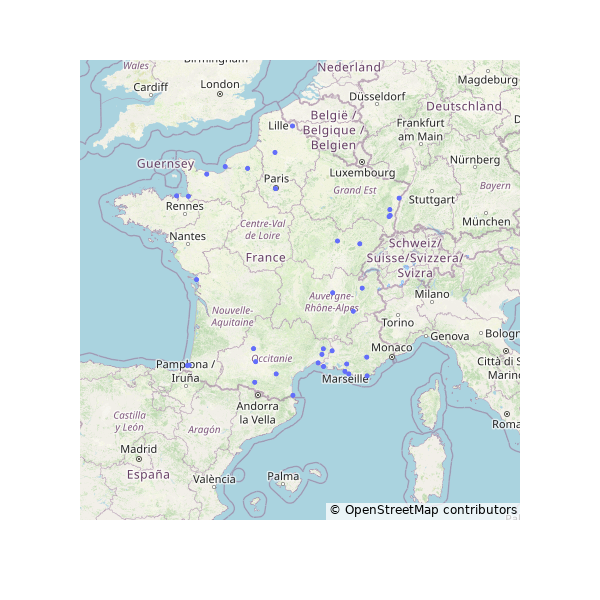

In [4]:
fig = px.scatter_map(cities_df, lat="latitude", lon="longitude", hover_data="name",
                        map_style="open-street-map", zoom = 4, height=600, width=600)
fig.update_geos(fitbounds="locations")
fig.show()
